## Subtask 0: Download the data

Import the important libraries

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import scipy.stats as sp


Using the unix command wget via line magic the data set can be downloaded

In [4]:
!wget -i expression.txt science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

--2016-10-14 15:48:30--  http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx
Auflösen des Hostnamens »science.sciencemag.org (science.sciencemag.org)« … 104.232.27.116
Verbindungsaufbau zu science.sciencemag.org (science.sciencemag.org)|104.232.27.116|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx [folgend]
--2016-10-14 15:48:30--  http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx
Wiederverwendung der bestehenden Verbindung zu science.sciencemag.org:80.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 26159119 (25M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Wird in »»aad0189_DataFileS5.xlsx.1«« gespeichert.

aad0189_DataFileS5. 100%[===================>]  24,95M   244KB/s    in 78s    

## Task 1: Data wrangling

Reading in the data with pandas read_excel function, rows including NA values get dropped

In [8]:
expression = pd.read_excel("aad0189_DataFileS5.xlsx",header=2)

In [9]:
exp = expression.copy()

In [10]:
exp.dropna(how='all',inplace=True)
exp.dropna(how='all',inplace=True,axis=1)

### Subtask 1.2: Average over different probesets for a gene and generate a dataframe containing each gene symbol (once)  as rows and the corresponding averaged expression values for each strain + condition as columns

Use the groupby function to get rid of the duplicate gene symbols

In [11]:
exp = exp.groupby('Gene').mean()

### Subtask 1.3: Quantile normalization: carry out a quantile normalization of the data (or not)

#### Subsubtask 1.3.1: Implement a ratio intensity plot (using matplotlib)

A ratio intensity plot plots the distribution of the red and green channel by the average intensity:

$R = log_2(R/G) = log_2(R) - log_2(G)$


$I = \frac{1}{2}log_2(RG) = \frac{1}{2}(log_2(R) + log_2(G))$

In [27]:
def plotRI(df,col1,col2):
    """
    This function plots a ratio intensity plot given a dataframe containing the expression data and the name of
    the two columns of the dataframe to be plotted against each other. The plot also contains a lowess regression
    indicated by the green line.
    
    @param df: The dataframe containing the expression data
    @param col1: Name of first column
    @param col2: Name of second column
    """
    e1 = df[col1]
    e2 = df[col2]
    RI = pd.DataFrame({col1: e1,col2:e2})
    RI['R'] = np.log2(RI[col2] / RI[col1])
    RI['I'] = 0.5* np.log2(RI[col2]) + np.log2(RI[col1])
    #RI.plot.scatter(x='I',y='R')
    lowess = sm.nonparametric.lowess
    lo = lowess(RI['R'],RI['I'])
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax.scatter(x=RI['I'],y=RI['R'])
    ax.plot(lo)
    ax.set_ylim(-1,1)
    ax.set_xlim(1,9)

#### Subsubtask 1.3.2: Apply your ratio intensity plot to several pairs of chips (columns of your above dataframe)

By calling the previously defined function with different parameters the plots are generated

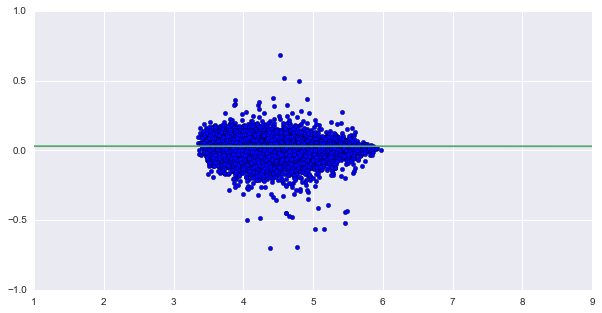

In [28]:
plotRI(exp,"C57BL/6J_Liver_CD","BXD90_Liver_HFD")

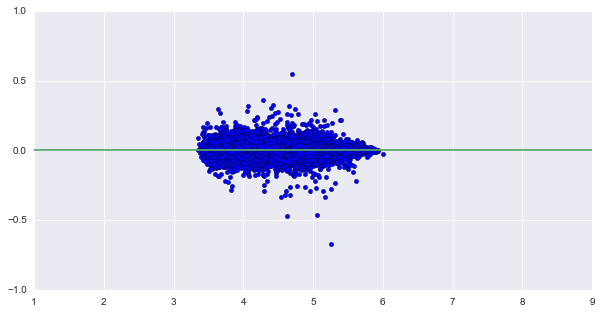

In [29]:
plotRI(exp,"BXD98_Liver_HFD","BXD101_Liver_HFD")

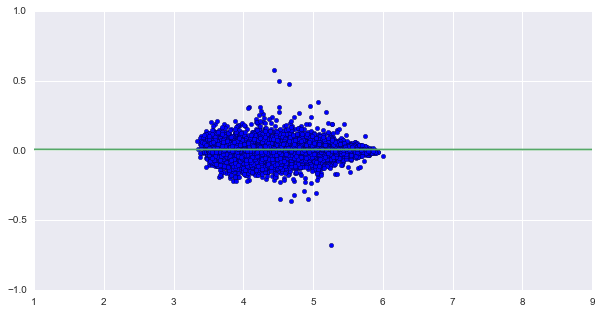

In [30]:
plotRI(exp,"BXD98_Liver_HFD","BXD96_Liver_HFD")

#### Subsubtask 1.3.3: Implement a rle plot (rle = relative log expression)

In [31]:
def plotRLE(data):
    """
    This function creates an rle plot of the dataframe.
    
    @param data: The dataframe containg the expression values.
    """
    medians = []
    rle = pd.DataFrame()
    i = 0
    fig,ax = plt.subplots(1,1,figsize=(25,5))
    for gene in data:
        if 'Liver' in gene:
            medians.append(data[gene].median())
            rle[gene] = data[gene] / medians[i]
    rle.boxplot(return_type = 'axes')

#### Subsubtask 1.3.4: Apply your RLE plot to the data

Using the previously defined function the RLE plot is created

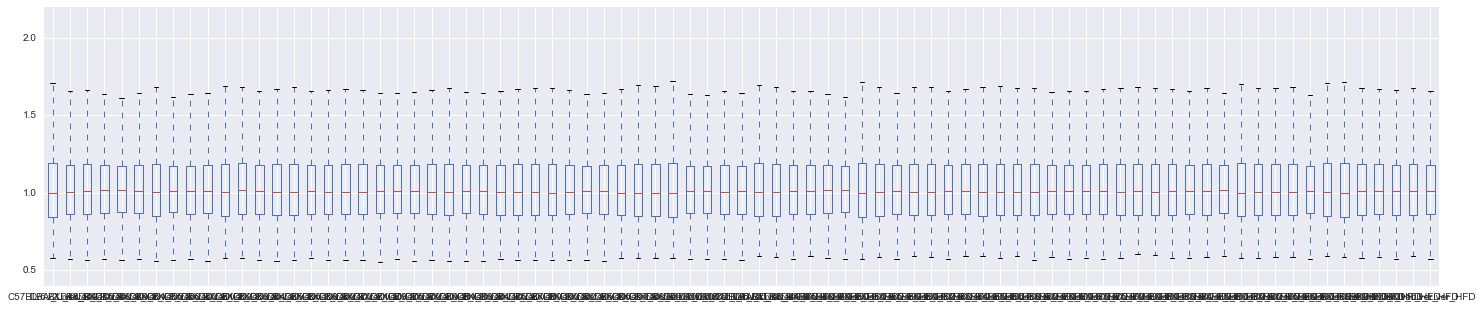

In [22]:
plotRLE(exp)

#### Subsubtask 1.3.5: If you consider it necessary, perform a quantile normalization of the data 

Quantile normalization is not neccesary here since the data is already normalized, as seen by the fact that most of the data is located around the x-axis in the RI plots (also the green line is almost the x-axis) and the boxplots of the data frame are all in line.

## Task 2: Which statistical test to chose?

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).

Everything you may need, is most likely found here:

http://docs.scipy.org/doc/scipy-0.17.1/reference/stats.html 

http://statsmodels.sourceforge.net/stable/graphics.html

### Subtask 2.1: Do the CD and HFD samples have equal variance?

#### Subsubtask 2.1.1: Choose a random row of your latest dataframe using the random module of Python

Using the random function a random row is chosen

In [33]:
import random
random = random.randint(0,21834)

#### Subsubtask 2.1.2: Make a Q-Q plot comparing the two samples for the just chosen gene and answer the question: Does this tell you anything?

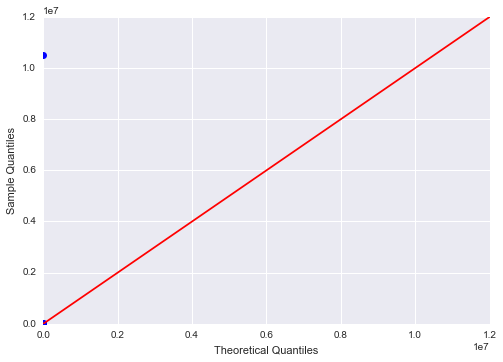

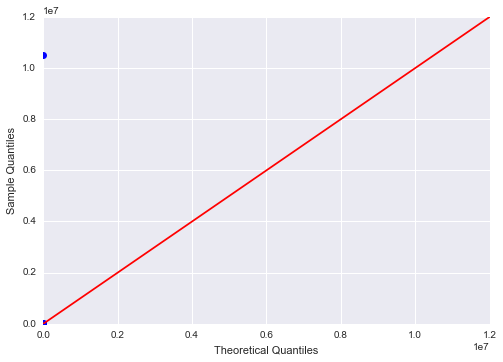

In [34]:
sm.graphics.qqplot(exp.ix[random],line="45",fit=False)

#### Subsubtask 2.1.3: Apply an appropriate statistical test in order to figure out whether the samples have equal variance (there may be more than one sensible solution)

In order to compare the two samples additional sub data frames are created containing only the HFD and CD columns, respectively.

Afterwards bartlett test is applied to the new data frames of the random gene first and afterwards to all genes to check vor equal variances 

In [125]:
cols = [c for c in exp.columns if c.upper()[-3:] != 'HFD']
exp_CD = exp[cols]
cols = [c for c in exp.columns if c.upper()[-3:] != '_CD']
exp_HFD = exp[cols]
cols = [c for c in exp.columns if c.upper()[-3:] == '_CD']
exp_CD = exp_CD[cols]
cols = [c for c in exp.columns if c.upper()[-4:] == '_HFD']
exp_HFD = exp_HFD[cols]
exp_CD = exp_CD.drop("BXD92_Liver_CD",axis=1)
exp_CD_random = exp_CD.ix[random]
exp_HFD_random = exp_HFD.ix[random]
sp.bartlett(exp_CD_random,exp_HFD_random)

BartlettResult(statistic=1.6024725469701782, pvalue=0.20555316647080668)

#### Subsubtask 2.1.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.1.3)

Using a for loop bartlett test is applied to every gene and a histogram of the results is plotted.

In [61]:
bartlett = pd.DataFrame()
for row in range(0,21834):
    result =  sp.bartlett(exp_CD.ix[row],exp_HFD.ix[row])
    bartlett.loc[row,'pvalue'] = result[1]

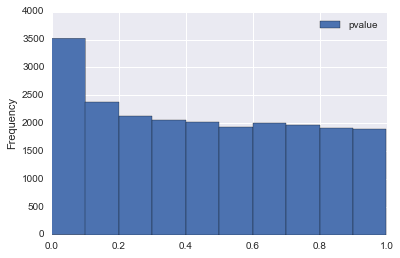

In [62]:
bartlett.plot.hist()

### Subtask 2.2 Are the CD and HFD samples normally distributed?

Utterly shocked and overwhelmed by ambiguous emotions you begin to doubt the wisdom of Josef-Francisco and start a top-secret and highly dangerous investigation whether the samples are at least normally distributed. Be careful whom you'll tell about that you're working on this...

#### Subsubtask 2.2.1: Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give an interpretation

In [63]:
random_gene_CD = pd.DataFrame(exp_CD.ix[random])

In [126]:
random_gene_HFD = pd.DataFrame(exp_HFD.ix[random])

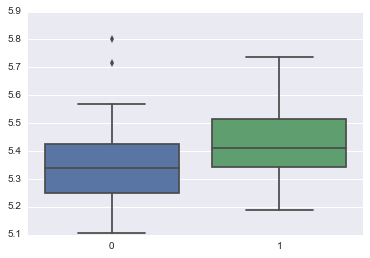

In [127]:
sns.boxplot(data=[random_gene_CD,random_gene_HFD])

The boxplot shows that the two samples have different medians. An explanation to this could be that the gene is in fact differentially expressed.

#### Subsubtask 2.2.2: Just like in 2.2.1 make Q-Q plots for each sample (compare each to the theoretical normal distribution) and try an interpretation.

In [66]:
sp.stats.zscore

<function scipy.stats.stats.zscore>

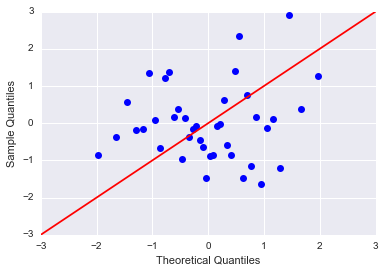

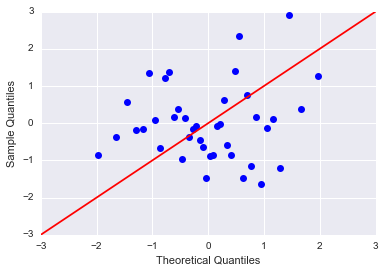

In [69]:
sm.graphics.qqplot(sp.stats.zscore(random_gene_CD, axis=0, ddof=0), line='45')

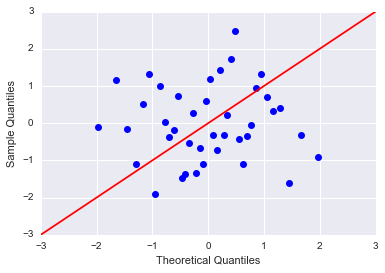

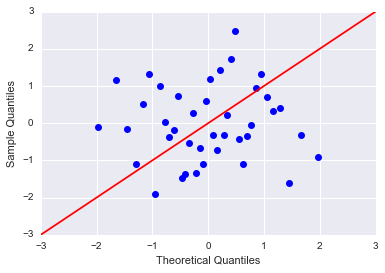

In [128]:
sm.graphics.qqplot(sp.stats.zscore(random_gene_HFD, axis=0, ddof=0), line='45')

A qqplot for each sample is drawn using standardized zscore. The plots do not show any linear context (diagonal line of plotted values is missing), meaning the two samples are not normally distributed.

#### Subsubtask 2.2.3: Apply an appropriate statistical test in order to figure out whether the samples are normally distributed (there may be more than one sensible solution)

In [71]:
sp.stats.mstats_basic.normaltest

<function scipy.stats.mstats_basic.normaltest>

In [72]:
_,pvalues_norm_HFD = sp.stats.mstats_basic.normaltest(exp_HFD.T)

In [73]:
_,pvalues_norm_CD = sp.stats.mstats_basic.normaltest(exp_CD.T)

In [74]:
pvalues_norm_CD

array([  4.12046571e-04,   3.38962471e-01,   9.28403023e-01, ...,
         1.66649856e-01,   8.26874929e-01,   3.36337116e-11])

In [75]:
pvalues_norm = pd.DataFrame(pvalues_norm_CD)

#### Subsubtask 2.2.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.2.3)

/Users/Timo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


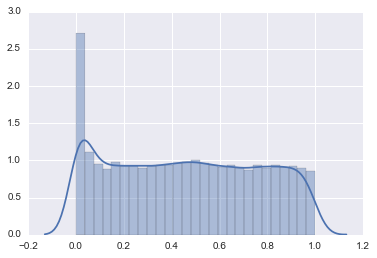

In [76]:
sns.distplot(pvalues_norm_HFD)

/Users/Timo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


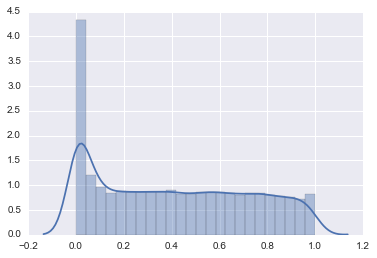

In [77]:
sns.distplot(pvalues_norm_CD)

In [ ]:
p_values_norm = pd.DataFrame()
for row in range(1,21834):
    result =  sp.bartlett(exp_CD.ix[row],exp_HFD.ix[row])
    bartlett.loc[row,'pvalue'] = result[1]

Comparing the histograms one can see the most genes are not normally distributed since the null hypothesis can not be rejected.

#### Subsubtask 2.2.5: Write a 1-word essay about whether there is any instrinsic philosophical reason that any data follows a normal distribution

No

### Subtask 2.3 Choose a suitable statistical test to assess differential expression, apply it to every row, store the results in a suitable dataframe (you may want to order the genes with respect to their p-values) and finally extract a list of differentially expressed genes (5% significance). How many differentially expressed genes do you get?

To test for differential expression the Wilcoxon-Mann-Whittney test is applied to every gene and the pvalues are stored in a separate data frame

In [129]:
sp.stats.mannwhitneyu(exp_CD["BXD44_Liver_CD"], exp_HFD["BXD44_Liver_HFD"], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=235969359.0, pvalue=0.034655684354446652)

In [130]:
def diffExp(df1,df2):
    """
    This Method checks if a gene is differentially expressed given two dataframes from 2 different strains
    containing expression values for each gene
    @param df1: first dataframe
    @param df2: second dataframe
    """
    exp_total = exp_HFD.join(exp_CD)
    pvalues_ttest = pd.DataFrame()
    pvalues = []
    for row in range(0,21834):
        #_, pvalue_ttest = sp.ttest_1samp(exp_total.ix[row],exp_total.ix[].mean()
        _, pvalue = sp.stats.mannwhitneyu(exp_CD.ix[row], exp_HFD.ix[row], use_continuity=False)
        #rowname = str(exp_total.T.columns[row])
        #pvalues_ttest[rowname] = pvalue
        pvalues.append(pvalue)
    pvalues_df = pd.DataFrame(pvalues)
    pvalues_df.index = exp.index
    pvalues_df.columns = ['p_values']
    return pvalues_df

In [131]:
pvalues = diffExp(exp_CD,exp_HFD)

In [85]:
pvalues = pvalues.sort_values(by = 'p_values')

## Task 3: Multiple-testing correction

You receive an anonymous letter revealing to you that you should do multiple-testing correction, otherwise something awfully bad will happen, or not. Puzzled and shaking you embark on this endeavour.

Fredholm, your lab's vodoo priest, is convinced that applying anything else than Bonferroni correction brings death and destruction to the people on the moon. Opportunistically neglecting any potential societal consequences of your actions (technology is neutral after all and who cares about the moon anyway!) you're obsessed to try as many multiple testing procedures as possible.

Everything you may need, is most likely found here:

http://statsmodels.sourceforge.net/stable/stats.html#multiple-tests-and-multiple-comparison-procedures

### Subtask 3.1: For your official report you have to pretend to care about Bonferroni's correction (otherwise it will never pass through Fredholm's office): manually code it (do not use the statsmodels implementation for example) and store the results in a suitable dataframe. How many differentially expressed gene do you get?

After using multiple testing correction one does now try to find the differentially expressed genes

In [102]:
def multipleTesting(pvalues_,method):
    if method != 'bonferroni':
        pvalues_corrected = sm.stats.multipletests(pvalues_['p_values'],method=method)
        pvalues_corrected = pd.DataFrame(pvalues_corrected[1])
    else:
        pvalues_corrected = pvalues_["p_values"] * len(pvalues_)
        pvalues_corrected = pd.DataFrame(pvalues_corrected)
    pvalues_corrected.index = pvalues_.index
    pvalues_corrected.columns = [method]
    pvalues_corrected = pvalues_corrected.sort_values(by=method)
    return pvalues_corrected

In [132]:
pvalues_filtered = pvalues[pvalues.p_values < 0.05]

#pvalues_filtered

Before applying the multiple testing correction to the p-values one does find over 13.000 differentially expressed genes.

### Subtask 3.2: Apply all multiple testing procedures you can get your hands on (except Bonferroni; now you should use statsmodels) to your uncorrected p-values and store the results in one (!) dataframe. 

In [139]:
pvalues_corrected = multipleTesting(pvalues_filtered,"bonferroni")

In [105]:
pvalues_corrected['sidak'] = multipleTesting(pvalues_filtered,"sidak")
pvalues_corrected['holm-sidak'] = multipleTesting(pvalues_filtered,"holm-sidak")
pvalues_corrected['simes-hochberg'] = multipleTesting(pvalues_filtered,"simes-hochberg")
pvalues_corrected['hommel'] = multipleTesting(pvalues_filtered,"hommel")
pvalues_corrected['fdr_tsbky'] = multipleTesting(pvalues_filtered,"fdr_tsbky")

In [90]:
#pvalues_corrected

### Subtask 3.3: External visual comparison of the different methods
1 Write the DE dataframe to a csv file.
2 add a row with either 'numeric' or 'factor' as the first row to describe the data schema and save the file
3 use [paco](http://parallelcoordinates.de/paco) to visualize your data in parallel coordinates
4 which of the multiple testing methods is the most stringent? What's the relation between the others?

In [91]:
pvalues_corrected.dropna(inplace = True) 

In [137]:
#pvalues_corrected[pvalues_corrected.sidak < 0.05]

After using sidak correction one gets 3347 differentially expressed genes

In [98]:
pvalues_corrected.to_csv("../IOFolder/pvalues_corrected.csv")

Bonferroni is the most stringent, the other methods imply more or less the same amount of differentially expressed genes

### Subtask 3.4: Select a random method applied in 3.2 and extract the corresponding list of differentially expressed genes. Is this list contain more or less genes than the list from 2.3? Does it contain more or less genes than your Bonferroni list? ;)

As a comparison I chose the list with the sidak corrected p values.The list contains 8000 less elements than the list from 2.3 and 30 genes more than the bonferroni list.  

## Task 4: Vulcano plots

Marie de la Stratonovich, the devious intellectual opponent of your (former) beloved idol Josef-Francisco Del-Marre-Doyle just received the glorious Popel prize (the first marsian scientist ever to reveive that prize) for copy-pasting the content of the following papers:

1) arXiv:1103.3434 (https://arxiv.org/abs/1103.3434)

2) http://www.ncbi.nlm.nih.gov/pubmed/23602812 (doi:10.1016/j.compbiolchem.2013.02.003)

Overwhelmed by these achievments (and motivated by your ever declining esteem for Josef-Francisco) your're immensely excited about the joyous prospect of carrying out out the following tasks:

### Subtask 4.1: Add a log2 fold change column to the data frame from 3.2 and store it as a csv file.

In [140]:
#pvalues_corrected

### Subtask 4.2:  Implement a Vulcano plot (from scratch using matplotlib)

In [141]:
#exp_CD.head()

### Subtask 4.3: Apply your Volcano plot implementation to the uncorrected p-values, as well as the corrected p-values from 3.4 (you should have two plots in the end ;))

In [146]:
def plotVolcano(pvalues_df,exp_sample1,exp_sample2):
    """
    This function plots a volcano plot (log2 fold change vs -log of p value dataframe)
    
    @param pvalues_df:  A data frame containing the p values obtained after testing for diffrentially expression
    @param exp_sample1: Data frame containing expression values that originated from the first sample
    @param exp_sample2: Data frame containing expression values that originated from the second sample
    
    """
    fold_change = pd.DataFrame(exp_sample1.T.mean() / exp_sample2.T.mean())
    log_fold_change = np.log2(fold_change)
    pvalues = pvalues_df.join(log_fold_change)
    pvalues.columns = ['p_values', 'log2_fold_change']
    volcano = pvalues
    volcano['p_values'] = -1*np.log10(volcano['p_values'])
    volcano.columns = ['-log_p_values', 'log2_fold_change']
    volcano.to_csv(path_or_buf = "../IOFolder/volcano.csv")
    volcano.plot.scatter(x='log2_fold_change',y='-log_p_values')

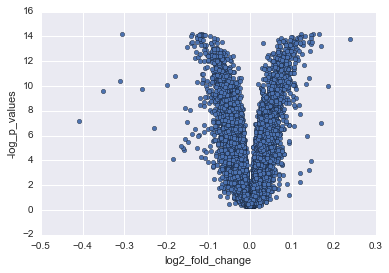

In [148]:
plotVolcano(pvalues,exp_CD,exp_HFD)

## Task 5: RNA-seq

RNA Seq can also be used to study gene expression. This technology uses methods from next or third generation sequencing to measure gene expression through determining the mRNA content of a sample.

The result of an RNA-seq experiment is a discrete read count rather than the information whether a gene is up or down regulation, this leaves more room for analysis and further applications such as the detection of new genes or alternative splice sites